# Churn Prediction on Credit Card Data 

**Overview** :
1. Get and download the data from kaggle, quick-learn about the data & the domain. Source :
    - https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers
2. **Dataset Overview** to preview the dataset information. Data cleaning to check if the data contain missing and duplicated values.
3. **EDA**, explore and extract the information. In this step contain statistical summary, uni- and multi-variate analysis, including the 'deep-dive question' and the summary.
4. **Data Preprocessing**, prepare the data before modeling. Missing value handling, multicollinearity study, encoding, split data into train-test. Due to the imbalance target, it use SMOTE to oversampling the train data. 
5. **ML Modeling**, build a prediction model by using supervised classifier learning (distance based ML : KNN, and tree based ML : Decision Tree, and Random Forest), and evaluating the model performance.
6. Expected output : the action insight / business recommendation based on the EDA, and optimized predictive model that can predict the churn.  

Objective :

- Studying the behavior of customers who choose churn.
- Build predictive models to predict CC customer churn.
- Provide recommendations to retain existing customers.

# Import Libraries

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# import library
import pandas as pd
import numpy as np

# vis lib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# split train-test
from sklearn.model_selection import train_test_split

# imputer 
from sklearn.impute import SimpleImputer

# imbalance handling
from imblearn.over_sampling import SMOTE

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # distance based ML
from sklearn.tree import DecisionTreeClassifier    # tree based ML
from sklearn.ensemble import RandomForestClassifier 

# hyperparameter tune
from sklearn.model_selection import GridSearchCV

# evaluation metric
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# permutation_importance
from sklearn.inspection import permutation_importance

In [2]:
# visualization set up
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Dataset Overview

The columns info
- `CLIENTNUM` : Client number. Unique identifier for the customer holding the account
- `Attrition_Flag` : Internal event (customer activity) variable - if the account is closed then 1 else 0
- `Customer_Age` : Demographic variable - Customer's Age in Years
- `Gender` : Demographic variable - M=Male, F=Female
- `Dependent_count` : Demographic variable - Number of dependents
- `Education_Level` : Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
- `Marital_Status` : Demographic variable - Married, Single, Divorced, Unknown
- `Income_Category` : Demographic variable - Annual Income Category of the account holder in $ (<40K, 40K - 60K, 60K - 80K, 80K-120K, 120K +)
- `Card_Category` : Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
- `Months_on_book` : Period of relationship with bank
- `Total_Relationship_Count` : Total no. of products held by the customer
- `Months_Inactive_12_mon` : No. of months inactive in the last 12 months
- `Contacts_Count_12_mon`: No. of Contacts in the last 12 months
- `Credit_Limit` : Credit Limit on the Credit Card
- `Total_Revolving_Bal` : Total Revolving Balance on the Credit Card
- `Avg_Open_To_Buy` : Open to Buy Credit Line (Average of last 12 months)
- `Total_Amt_Chng_Q4_Q1` : Change in Transaction Amount (Q4 over Q1)
- `Total_Trans_Amt` : Total Transaction Amount (Last 12 months)
- `Total_Trans_Ct` : Total Transaction Count (Last 12 months)
- `Total_Ct_Chng_Q4_Q1` : Change in Transaction Count (Q4 over Q1)
- `Avg_Utilization_Ratio` : Average Card Utilization Ratio

**Reference for each CC term :** https://www.creditcards.com/glossary/

- A revolving balance is the portion of 'credit card spending' that goes unpaid at the end of a billing cycle.
- Open-to-Buy: The difference between the credit limit assigned to a cardholder account and the present balance on the account.
- Utilization ratio is used in the calculation of credit scores. It compares the amount of credit being used to the total credit available to the borrower. 

In [39]:
# read the data
data = pd.read_csv('drive/MyDrive/Finpro/BankChurners.csv')

# exclude 2 last columns
data = data[data.columns[:-2]]
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

- The data consist of 10127 rows and 21 columns.
- Some of categorical data still in `object` data types. All of numerical data are in correct type.
- No need to use `CLIENTNUM` (client number) at this analysis.
- The target is `Attrition_Flag`, customer separated into Attrited Customer and Existing Customer.

In [41]:
# drop CLIENTNUM
data = data.drop('CLIENTNUM', axis=1)

# lowercase the column name
data.columns = data.columns.str.lower()  

## Data Cleaning
check if data has missing and duplicate values

In [42]:
# duplicated check
data.duplicated().sum()

0

In [43]:
# missing check
data.isnull().sum()

attrition_flag              0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
dtype: int64

## Data Type
Dividing the data by its type into the numerical and the categorical data

In [44]:
# numerical data
# the numerical filter, for all column that contain 'numeric' values
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print('Total numerical columns :', data.select_dtypes(include=numerics).shape[1]) # check total columns

# the numerical data
data_num = data.select_dtypes(include=numerics)
data_num.head(3)

Total numerical columns : 14


,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000


In [45]:
# categorical data
# the categorical filter, by using exclude=numerics
print('Total categorical columns :', data.select_dtypes(exclude=numerics).shape[1]) # check total columns

# the categorical data
data_cat = data.select_dtypes(exclude=numerics)
data_cat.head(3)

Total categorical columns : 6


,attrition_flag,gender,education_level,marital_status,income_category,card_category
0,Existing Customer,M,High School,Married,$60K - $80K,Blue
1,Existing Customer,F,Graduate,Single,Less than $40K,Blue
2,Existing Customer,M,Graduate,Married,$80K - $120K,Blue


# EDA
The EDA step consist of statistical summary, univariate analysis, multivariate analysis, and the deep-dive question. Every sub-steps contain a general observation to build a data understanding/ data knowledge. 

## Statistical Summary
- Inspecting the numerical data by using the statistical summary and learn how they distributed.
- Get the highest frequent and total nunique value from categorical data.

In [46]:
# numerical
data_num.describe()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [47]:
# categorical
data_cat.describe()

,attrition_flag,gender,education_level,marital_status,income_category,card_category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


**Summary**
- Some of numerical columns have skewed distribution (mean > median) : `credit_limit, avg_open_to_buy, total_trans_amt, and avg_utilization_ratio`. The value within all columns seems normal by the min-max values.
- Most of customer are : 
    - Still exist ('Existing Customer' at attrition_flag columns)
    - Female
    - Graduate
    - Married
    - Having income less than $40K
    - Using Blue card

## Univariate Analysis
check the distribution of numerical data, and visualizing the categorical data

### Numerical

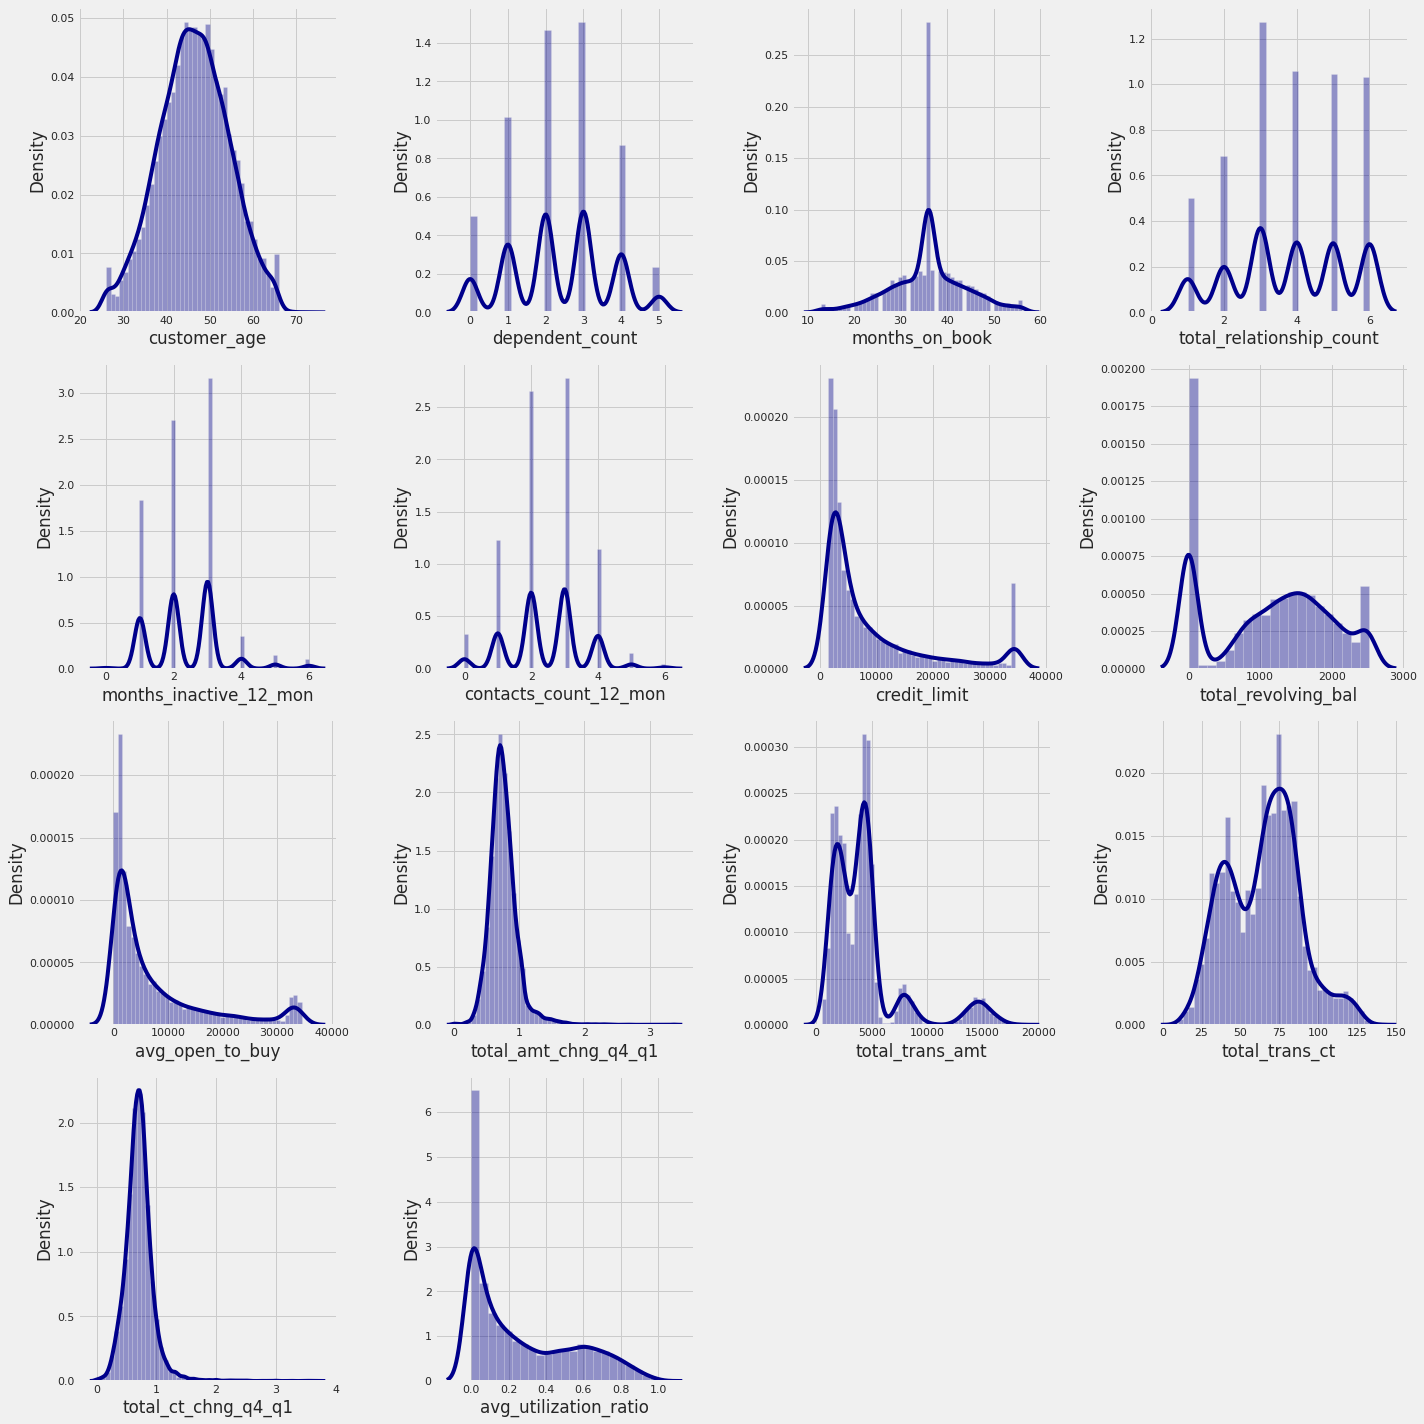

In [48]:
# Validating the distribution form using KDE plot 
# Setup figure
cols = 4
rows = 4
fig = plt.figure(figsize=(20,20))

# Plotting
features = data_num
for i, col in enumerate(features):
    ax = fig.add_subplot(rows, cols, i+1)
    sns.distplot(x=data[col], color='darkblue', ax=ax)
    plt.xlabel(col)
fig.tight_layout()
plt.show()

**Observation**

By using the density plot, some of skew distribution detected. Here are some summary for every columns.
- `customer_age`, the age has a normal distribution, and the highest density at 40-50 y.o.
- `dependent_count`, the customer dependents are mostly distributed in the range 2-3 dependents.
- `months_on_book`, the period of relationship between customer and bank are highly distributed at 35 months.
- `total_relationship_count`, the highest total product that customer hold are 3 products.
- `months_inactive_12_mon`, in the last 12 months, the highest total months of inactive customers was 3 months.
- `contacts_count_12_mon`, in the last 12 months, the highest number of contacts was 3 contacts.
- `credit_limit`, the credit limit mostly distributed at < 10k.
- `total_revolving_bal`, the total revolving balance highly distributed in the value < 500, then followed by range of 500-2500.
- `avg_open_to_buy`, the average open-to-buy (last 12 months) was highly distributed at < 10k.
- `total_amt_chng_q4_q1`, the change in transaction amount (Q4 over Q1) mostly distributed in the range 0.5-1.
- `total_trans_amt`, the total transaction amount (last 12 months) was highly distributed at < 5k.
- `total_trans_ct`, the total transaction count (last 12 months) was highly distributed at range 25-100 counts.
- `total_ct_chng_q4_q1`, the change in transaction count (Q4 over Q1) are mostly distributed at < 1.
- `avg_utilization_ratio`, the average of utilization ratio of customer are mostly distributed at < 0.2.

### Categorical

In [49]:
# the function for categorical data visualization
def vis_categoric(column):
    # counting value
    tmp = data[column].value_counts().reset_index()
    tmp.columns = [column, 'count']                   # temporary column
    
    # percentage
    total_ct = tmp.iloc[:,1].sum()                    # the total_count

    # loop for counting %-age
    percentage = []
    for i in range(tmp.shape[0]):                     # loop until range(total rows in tmp)
        pct = (tmp.iloc[:,1][i] / total_ct) * 100     # % = (tmp.col1.row[i] / total_count) * 100 
        percentage.append(round(pct, 2))

    tmp['percentage'] = percentage                    # assigning to the tmp
 
    # the visualization
    plt.figure(figsize=(8, 6))
    colors_list = ['darkblue', 'darkred']
    graph = plt.bar(tmp.iloc[:,0], tmp.iloc[:,1],     # plt.bar(tmp.col0, tmp.col1)
                    color=colors_list)
    plt.title('Percentage of '+ tmp.columns[0].capitalize())

    # loop for placing the %-age
    i = 0
    for p in graph:                                   # loop for every bar(p) at the graph
        width = p.get_width()                         # get bar width
        height = p.get_height()                       # get bar height
        x, y = p.get_xy()                             # get bar x,y
        plt.text(x+width/2, y+height*1.01, str(tmp.percentage[i])+'%', ha='center')
        i += 1
    plt.show()

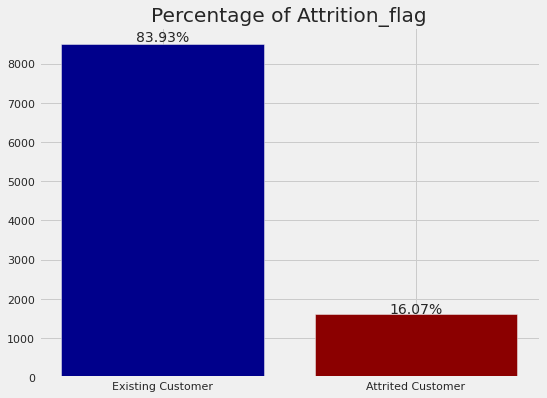

In [50]:
# categorical data visualization
# vis_categoric(column)
# the 'column' can be changed with every columns in data_cat.columns to get the figure

# attrition_flag
vis_categoric('attrition_flag')

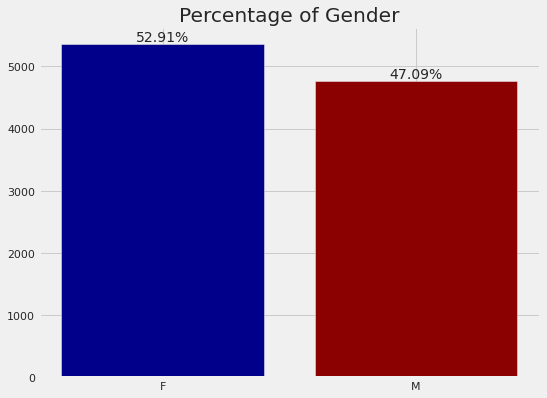

In [51]:
# gender
vis_categoric('gender')

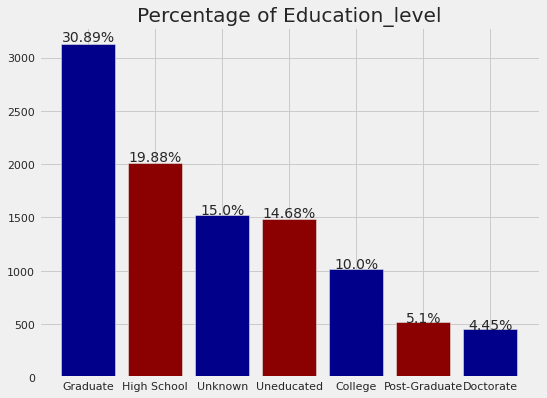

In [52]:
# education_level
vis_categoric('education_level')

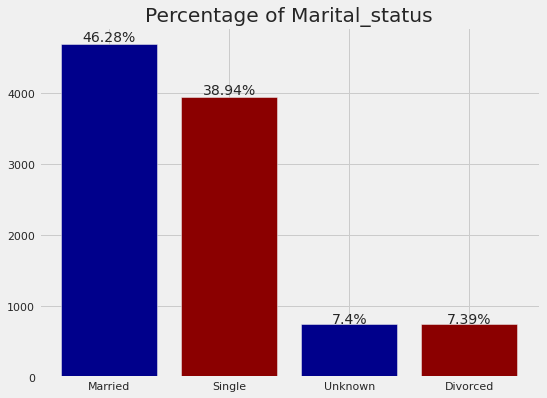

In [53]:
# marital_status
vis_categoric('marital_status')

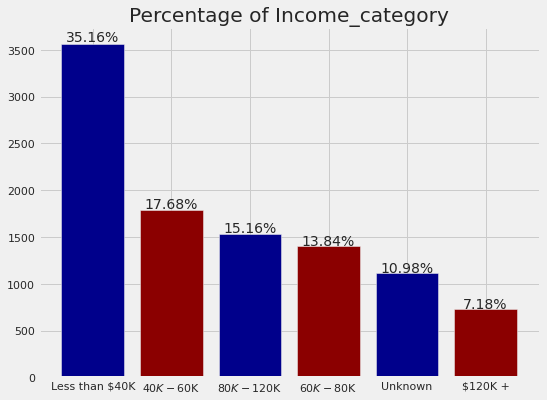

In [54]:
# income_category
vis_categoric('income_category')

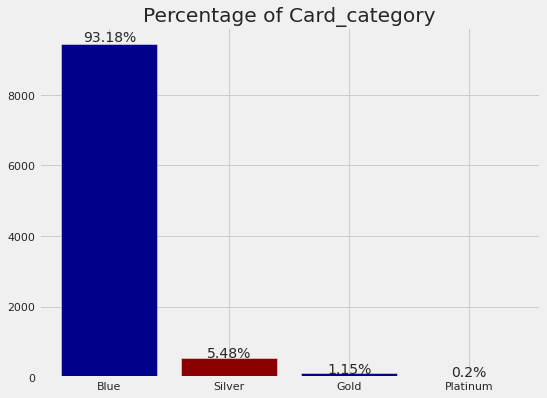

In [55]:
# card_category
vis_categoric('card_category')

**Observation**
- `attrition_flag`, the target show an attrition-rate dominated by Existing Customer 83% (a.k.a retained or not churn), so the data is imbalance.
- `gender`, the customer gender dominated by F (Female) 53%.
- `education_level`, the card holder dominated by Graduated person 31%.
- `marital_status`, mostly customer are Married 46%, then followed by Single 39%.
- `income_category`, most of the customer income (35%) are in category Less than $40K.
- `card_category`, the customer card is dominated by Blue card 93%.

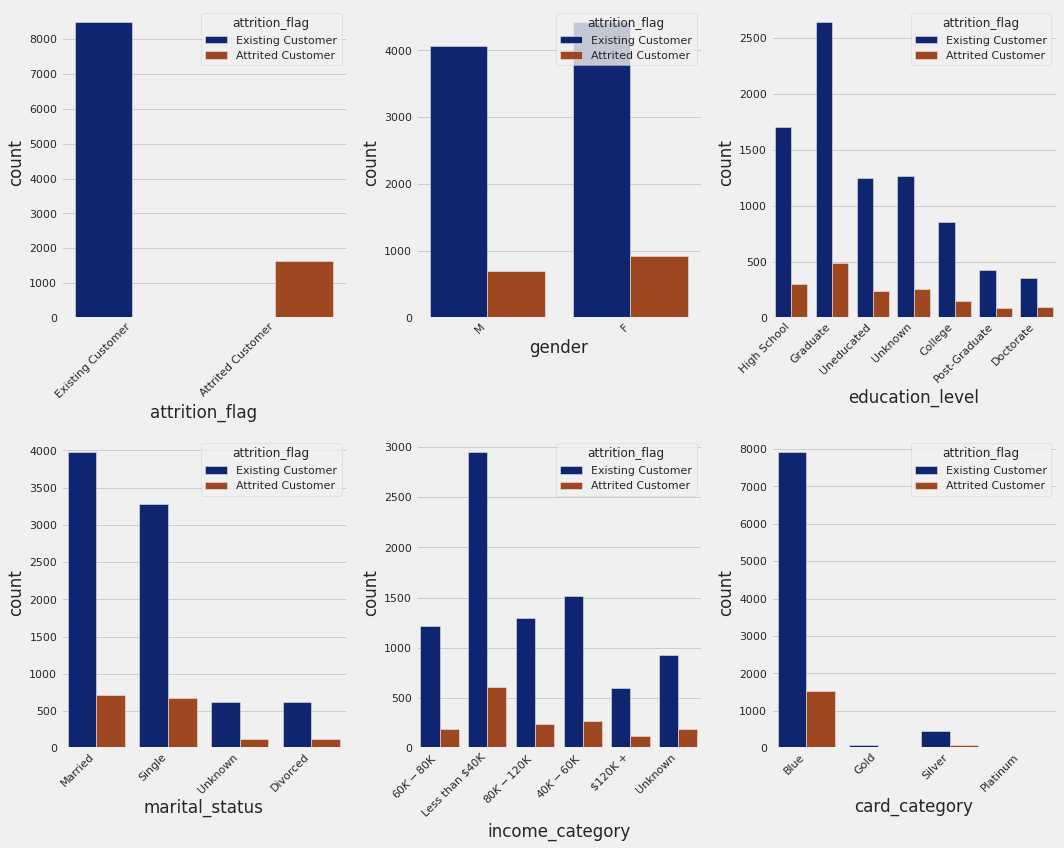

In [56]:
# the categorical column visualization based on attrition-rate
# setup the figure
cols = 3
rows = 2
fig = plt.figure(figsize = (15,12))

# looping for the plot
categoric_columns = data_cat                       # the data
for i, col in enumerate(categoric_columns):        # loop as long as counted-value in the data
    ax = fig.add_subplot(rows, cols, i+1)          # axes for subplot
    sns.countplot(data = categoric_columns,
                  x = data[col], 
                  hue = 'attrition_flag', 
                  ax = ax, palette='dark')    
    plt.xticks(rotation = 45, ha = 'right')
fig.tight_layout()  
plt.show()

**Observation**
- `attrition_flag`, Existing Customer as retained, and Attrited Customer as churned.
- `gender`, most of retained customer are M (Male).
- `education_level`, mostly churned customer are High School, and Graduate.
- `marital_status`, the churn rate between Married and Single look similar.
- `income_category`, customers in level 120K+ income has the lowest churn rate rather than the others.
- `card_category`, the Blue card holder has the bigger churn. But the better card doesnt always have the lowest churn, like Gold compared to Silver card.

## Multivariate Analysis 
Check the corresponding value between two features. The positive value indicate a positive correlation, assuming X and Y feature, it means the X tend to be large when Y is large and small when Y is small. The negative value means the opposite.

In [57]:
# replace value for the target
data['attrition_flag'] = data['attrition_flag'].str.replace('Existing Customer','0').str.replace('Attrited Customer','1').astype('float64')

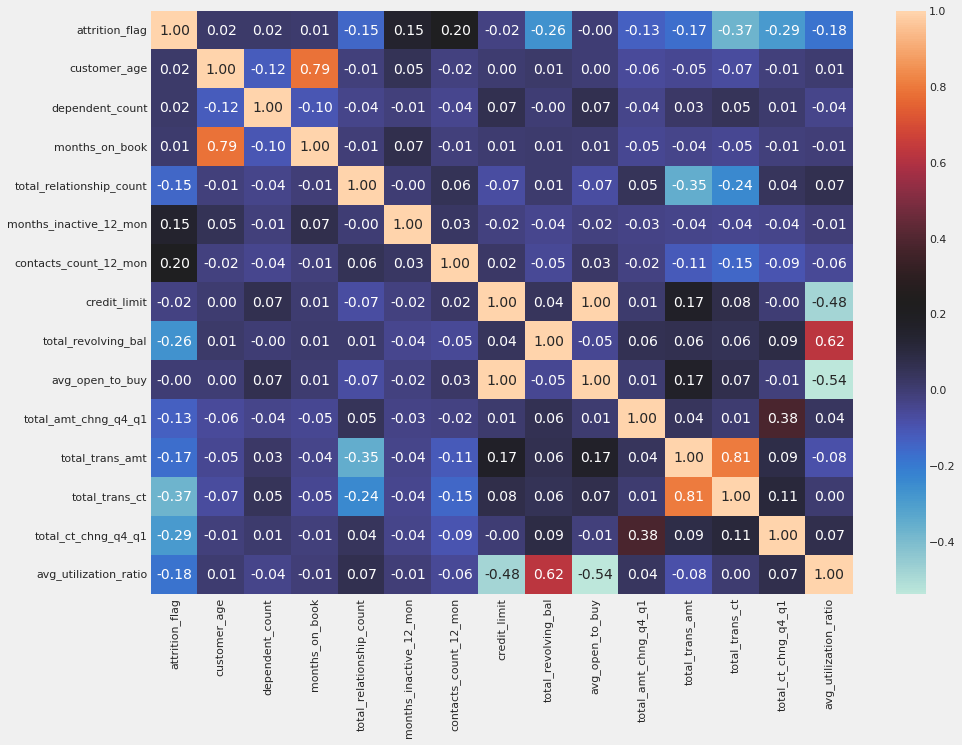

In [58]:
# correlation heatmap df
plt.figure(figsize=(14,10))
correlation = data.corr()
sns.heatmap(correlation, cmap='icefire', annot=True, fmt='.2f') 

**Observation**

There are 4 pair features that has a high - moderate (abs) correlation value.
- `avg_open_to_buy` with `credit_limit` (1.00)
- `total_trans_ct` with `total_trans_amt` (0.81)
- `months_on_book` with `customer_age` (0.79)
- `avg_utilization_ratio` with `total_revolving_bal` (0.62)

One of the features in each pair will be removed/dropped before the modeling, so the model can avoid multicollinearity column that contain redundant values.

## Deep-Dive Question
The deep-dive question are helping to get more insight from the data, beyond the standard EDA summary. The reason of doing this is to restrict the scope of the analysis, and avoid pointless direction step.

### Question 1
What are the categories of cards that choose to churn and their average months on book? Then what is the average total transaction they had spend?

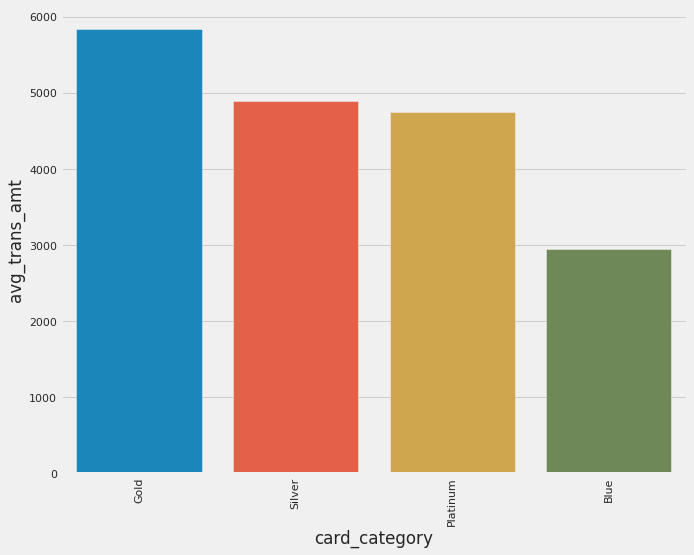

,attrition_flag,card_category,card_count,avg_trans_amt,avg_months
0,1.0,Gold,21,5841.809524,33.904762
1,1.0,Silver,82,4899.682927,36.365854
2,1.0,Platinum,5,4755.800000,36.000000
3,1.0,Blue,1519,2954.164582,36.200132


In [59]:
# attrition_flag, card_category, total_trans_amt, months_on_book

tmp = data[data['attrition_flag']==1]                      # the churned user = attrited customer

quest = (tmp.groupby(['attrition_flag', 'card_category'])
         .agg(card_count = ('card_category', 'count'),
              avg_trans_amt = ('total_trans_amt', 'mean'),
              avg_months = ('months_on_book', 'mean'))
         .sort_values('avg_trans_amt', ascending=False)
         .reset_index())

# the vis of quest 1
plt.figure(figsize=(10,8))
sns.barplot(data=quest,
            x='card_category',
            y='avg_trans_amt')
plt.xticks(rotation=90)
plt.show()
quest

**Observation**

The churned customer behaviour can be summarized as :
- The higher card category that used to churn didnt always have higher average transaction amount. For example Platinum < Gold in average transaction amount values, 4755.8 vs 5841.8.
- Above the average 33 months on book, the customer tend to churn, as we can see at the Gold card, as a border with the smallest values.

### Question 2
How is the distribution of the most active cards based on the customer's marital status that choose to churn?

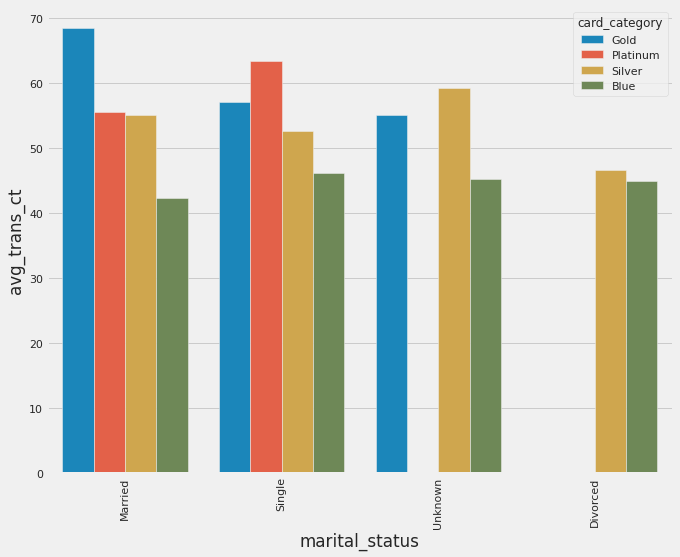

,attrition_flag,marital_status,card_category,avg_trans_ct
0,1.0,Married,Gold,68.333333
1,1.0,Single,Platinum,63.333333
2,1.0,Unknown,Silver,59.200000
3,1.0,Single,Gold,57.000000
4,1.0,Married,Platinum,55.500000
5,1.0,Unknown,Gold,55.000000
6,1.0,Married,Silver,54.962963
7,1.0,Single,Silver,52.627907
8,1.0,Divorced,Silver,46.571429
9,1.0,Single,Blue,46.058920


In [60]:
# card_category, marital_status, total_trans_ct (avg)

tmp = data[data['attrition_flag']==1]

quest = (tmp.groupby(['attrition_flag', 'marital_status', 'card_category'])
          .agg(avg_trans_ct = ('total_trans_ct', 'mean'))
          .sort_values('avg_trans_ct', ascending=False)
          .reset_index())

# the vis of quest 2
plt.figure(figsize=(10,8))
sns.barplot(data=quest,
            x='marital_status',
            y='avg_trans_ct', hue='card_category')
plt.xticks(rotation=90)
plt.show()

quest

**Observation**

The churned customer behaviour can be summarized as :
- The most active card with the biggest average transaction count is Gold card that owned by Married customer, with 68 transactions.
- Single customer with Platinum card has the highest transaction counts (63 counts) rather than other card that owned by this customer. 

Due to the higher average transaction counts, it can be assumed that the higher the card represent the higher demand to the service, but also followed by the 'tend to churn' risk.

### Question 3
What is the average credit limit, and what is the average revolving balance for each card owned by productive customers (age <64) who choose to churn?

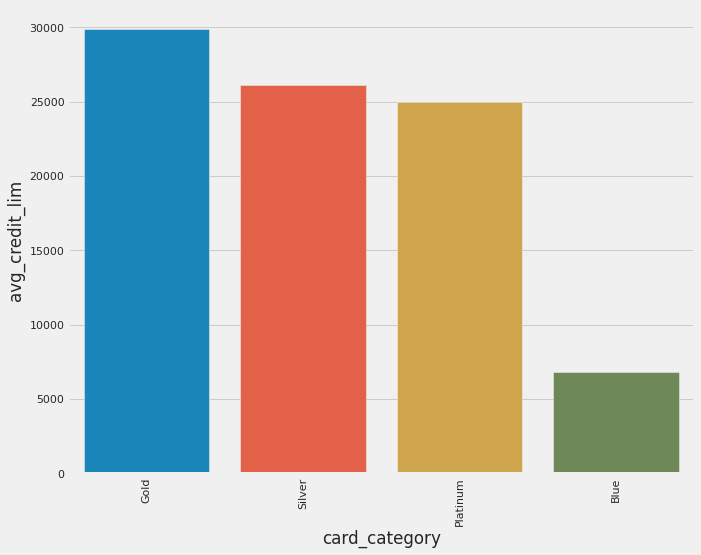

,attrition_flag,card_category,avg_credit_lim,avg_revolving_bal
0,1.0,Gold,29878.523810,1027.000000
1,1.0,Silver,26146.382716,663.901235
2,1.0,Platinum,24997.400000,263.400000
3,1.0,Blue,6837.320013,668.961564


In [61]:
# attrition_flag, card_category, credit_limit(avg), total_revolving_bal(avg)

# filter : the churned productive customer
tmp = data[(data['attrition_flag']==1) & (data['customer_age'] <= 64)]

quest = (tmp.groupby(['attrition_flag', 'card_category'])
          .agg(avg_credit_lim = ('credit_limit', 'mean'), 
               avg_revolving_bal = ('total_revolving_bal', 'mean'))
          .sort_values('avg_credit_lim', ascending = False)
          .reset_index())

# the vis of quest 3
plt.figure(figsize=(10,8))
sns.barplot(data=quest,
            x='card_category',
            y='avg_credit_lim')
plt.xticks(rotation=90)
plt.show()

quest

**Observation**

The churned customer behaviour can be summarized as :
- The bigest average credit limit are at Gold card, then followed by Silver, Platinum, and Blue.
- The average revolving balance represent the unpaid previous bill that carried from previous months. The lowest one is Platinum users, but the highest one is Gold user.

The higher the card types, it is not always in line with the responsibility to pay bills, for example the Silver vs the Gold average revolving balance, 663 vs 1027. The bigger received bill (revolving balance), the more risk the customer to run away, in case they cant pay the bill.

## Summary
Here are some assumptions from the standard EDA and the deep-dive question above :
- Customer tend to churn if they had a big value in transaction amount, credit limit, and revolving balance.
- As we can see from some observation, The Gold card users are the problematic-one rather than the others, but also be the valuable-one to maintain due to the higher impact in business : 
    - Big average transaction amount and big average transaction count, can lead to a profit.
    - Big average revolving balance, can cause a resource loss.

Some factor that need to be monitored :
- **Transaction amount and credit limit**. The bigger their value, the bigger 'risk' if the users cant pay the bill. In order to retain the customer that have a big amount both transaction amount, & credit limit, on CC, we suggest to add more benefical-products. Here are the recomended benefical-product : 
    - *Travel point*, point that can be converted into a ticket flight or hotel.
    - *Special point*, point that can give a cashback voucher or discount in special product.

- **Revolving balance**. The revolving balance represent the unpaid bill that carries over months. A bigger value also brings the risk with it. We add some suggest to :
    - The existing customer, set a reminder due to the spending limit cap in every month. So it can be a warn if they have an unpaid bills.
    - The potential customers, applying the Know Your Customer (KYC) to be able to reject customers if they are classified as risky customers. Thus is a way to prevent big revolving balance at the future, and prevent the balance loss.

# Data Preprocessing
Data preprocessing goals is to preparing the data before it is get into model. Some of the preprocessing are : 
- Missing values handling
- Multicollinearity handling
- Encoding
- Split train-test
- Oversample (SMOTE)

## Missing Values Handling
There is no NULL data in the dataset, but we detected an 'Unknown' expressions at the EDA step. It is found at `education_level`, `marital_status`, and `income_category` columns. So we choose to label it into a 'missing values' due to the unwillingness filling information. Imputing the categorical data by most frequent value.

In [62]:
# converting the 'Unknown' value
data.education_level[data['education_level'] == 'Unknown'] = None
data.marital_status[data['marital_status'] == 'Unknown'] = None
data.income_category[data['income_category'] == 'Unknown'] = None

# re-check the missing values
data.isna().sum()

attrition_flag                 0
customer_age                   0
gender                         0
dependent_count                0
education_level             1519
marital_status               749
income_category             1112
card_category                  0
months_on_book                 0
total_relationship_count       0
months_inactive_12_mon         0
contacts_count_12_mon          0
credit_limit                   0
total_revolving_bal            0
avg_open_to_buy                0
total_amt_chng_q4_q1           0
total_trans_amt                0
total_trans_ct                 0
total_ct_chng_q4_q1            0
avg_utilization_ratio          0
dtype: int64

In [63]:
# encode the value into numerical type for the imputer step, and multicollinearity study
# label encoding
data['gender'] = data['gender'].replace({'F':1,'M':0})
data['marital_status'] = data['marital_status'].replace({'Divorced':0,'Married':1,'Single':2})

# ordinal encoding
data['education_level'] = data['education_level'].replace({'Graduate':0,
                                                           'High School':1,
                                                           'Uneducated':2,
                                                           'College':3,
                                                           'Post-Graduate':4,
                                                           'Doctorate':5})
data['income_category'] = data['income_category'].replace({'Less than $40K':0,
                                                           '$40K - $60K':1,
                                                           '$60K - $80K':2,
                                                           '$80K - $120K':3,
                                                           '$120K +':4,})
data['card_category'] = data['card_category'].replace({'Blue':0,
                                                       'Silver':1,
                                                       'Gold':2,
                                                       'Platinum':3})

In [64]:
# the imputer function
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

# the target
data['education_level'] = imputer.fit_transform(data['education_level'].values.reshape(-1, 1))
data['marital_status'] = imputer.fit_transform(data['marital_status'].values.reshape(-1, 1))
data['income_category'] = imputer.fit_transform(data['income_category'].values.reshape(-1, 1))

# re-check after imputing values
data.isna().sum()

attrition_flag              0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
dtype: int64

## Multicollinearity Study
Follow up from multivariate analysis in EDA. Drop the multicollinarity features.

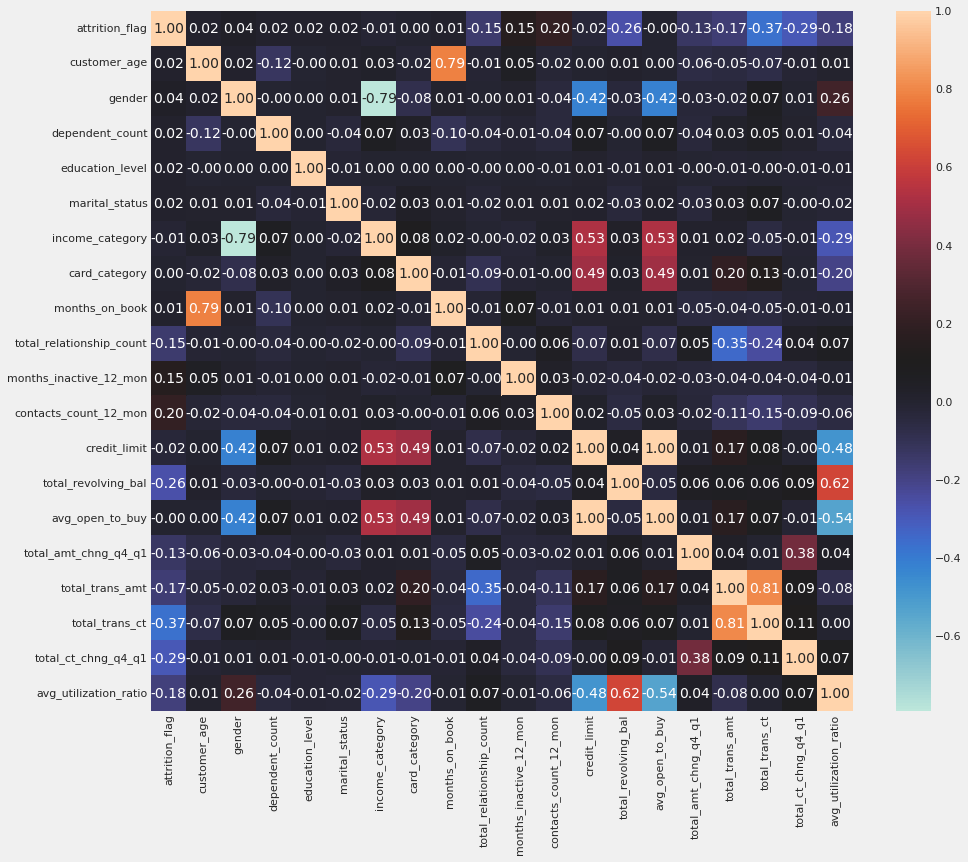

In [65]:
# check multicollinearity by using correlation heatmap 
plt.figure(figsize=(14,12))
correlation = data.corr()
sns.heatmap(correlation, cmap='icefire', annot=True, fmt='.2f')

The each pairs that has a high absolute correlation value (above 0.7)
- `income_category` with `gender` (0.79)
- `months_on_book` with `customer_age` (0.79)
- `avg_open_to_buy` with `credit_limit` (1.00)
- `total_trans_ct` with `total_trans_amt` (0.82)

After the consecutive trial-error step, we drop `income_category`, `months-on-books`, `avg_open_to_buy`, and `total_trans_ct`

In [66]:
# drop one feature from each pairs
data = data.drop(['income_category', 'months_on_book', 'avg_open_to_buy', 'total_trans_ct'], axis=1)
data.head(3)

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,card_category,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,avg_utilization_ratio
0,0.0,45,0,3,1.0,1.0,0,5,1,3,12691.0,777,1.335,1144,1.625,0.061
1,0.0,49,1,5,0.0,2.0,0,6,1,2,8256.0,864,1.541,1291,3.714,0.105
2,0.0,51,0,3,0.0,1.0,0,4,1,0,3418.0,0,2.594,1887,2.333,0.000


## Encoding
The encode divided into two type, label encode and One-Hot encoding. Label Encode to `gender`, and One-Hot encoding to `education_level`, `marital_status`, and `card_category`.

In [67]:
# the One-Hot encode
data = pd.get_dummies(data=data,
                      columns=['education_level', 'marital_status', 'card_category'],
                      drop_first=True)

In [68]:
data.head(3)

,attrition_flag,customer_age,gender,dependent_count,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,...,education_level_1.0,education_level_2.0,education_level_3.0,education_level_4.0,education_level_5.0,marital_status_1.0,marital_status_2.0,card_category_1,card_category_2,card_category_3
0,0.0,45,0,3,5,1,3,12691.0,777,1.335,...,1,0,0,0,0,1,0,0,0,0
1,0.0,49,1,5,6,1,2,8256.0,864,1.541,...,0,0,0,0,0,0,1,0,0,0
2,0.0,51,0,3,4,1,0,3418.0,0,2.594,...,0,0,0,0,0,1,0,0,0,0


## Split Data
Split the data into train-test, 70:30

In [69]:
data_X = data.drop('attrition_flag', axis=1)      # features
data_y = data['attrition_flag']                   # target

# train : test = 70 : 30
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=89)

In [70]:
# check the data after split train-test
print('data_X shape\t:', data_X.shape)
print('data_y shape\t:', data_y.shape)
print()
print('X_train shape\t:', X_train.shape)
print('y_train shape\t:', y_train.shape)
print()
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

data_X shape	: (10127, 22)
data_y shape	: (10127,)

X_train shape	: (7088, 22)
y_train shape	: (7088,)

X_test shape: (3039, 22)
y_test shape: (3039,)


#### BASELINE
The logistic regression as a baseline for the classification model. Resulting recall score 37 %. 

In [71]:
# baseline
# logistic regression function
lr = LogisticRegression()
  
# train the model on train set
lr.fit(X_train, y_train)
  
predictions = lr.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      2518
         1.0       0.76      0.37      0.50       521

    accuracy                           0.87      3039
   macro avg       0.82      0.68      0.71      3039
weighted avg       0.86      0.87      0.85      3039



## Oversample SMOTE
As we know from the EDA, the data is imbalance, Existing vs Attrited Customer, 84 % : 16 %. The imbalance data will give a bad result into ML, so we need avoid it by using SMOTE method (Synthetic Minority Oversampling TEchnique) on training data.

In [72]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# SMOTE
sm = SMOTE(random_state = 89)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 1106
Before OverSampling, counts of label '0': 5982 

After OverSampling, the shape of train_X: (11964, 22)
After OverSampling, the shape of train_y: (11964,) 

After OverSampling, counts of label '1': 5982
After OverSampling, counts of label '0': 5982


# Modeling
We build some model to predict the `churn` on the data, and applying hyperparameter tuning in each model, exclude the baseline.
- Baseline (logistic regresion)
- KNN
- Decision Tree
- Random Forest

#### BASELINE (UPDATED) 

In [73]:
# train the model on train set, using the oversampled data
lr.fit(X_train_res, y_train_res)
  
predictions = lr.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.93      0.76      0.84      2518
         1.0       0.38      0.74      0.50       521

    accuracy                           0.75      3039
   macro avg       0.66      0.75      0.67      3039
weighted avg       0.84      0.75      0.78      3039



baseline (logreg) recall score on original data & pasca smote = 37 % & 74 %

## KNN

In [74]:
%%time
# defining the knn
knn = KNeighborsClassifier()

# the hyperparameter tuning
params_knn = {
    'n_neighbors': (range(2,22)),          
    'weights':('uniform','distance')           # 20x2 = 40 combinations
}

# fit grid search cv
knn_gridcv = GridSearchCV(knn, params_knn, cv=5, scoring='f1')
knn_gridcv.fit(X_train_res, y_train_res)

CPU times: user 1min 47s, sys: 21.6 s, total: 2min 8s
Wall time: 1min 35s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 22),
                         'weights': ('uniform', 'distance')},
             scoring='f1')

## Decision Tree Classifier

In [75]:
%%time
# defining the decision tree
dt = DecisionTreeClassifier(random_state=89)

# the hyperparameter tuning
params_dt = {
    'max_depth': (2, 3, 5, 7, 10, 15, 17, 20),
    'min_samples_leaf': (5, 10, 20, 50, 100)      # 8x5 = 40 combinations
}

# fit grid search cv
dt_gridcv = GridSearchCV(dt, params_dt, cv=5, scoring='f1')
dt_gridcv.fit(X_train_res, y_train_res)

CPU times: user 13.2 s, sys: 4.67 ms, total: 13.2 s
Wall time: 13.2 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=89),
             param_grid={'max_depth': (2, 3, 5, 7, 10, 15, 17, 20),
                         'min_samples_leaf': (5, 10, 20, 50, 100)},
             scoring='f1')

## Random Forest

In [76]:
%%time
# defining the random forest model
rf = RandomForestClassifier(random_state=89)

# the hyperparameter tuning
params_rf = {
    'max_depth': (2, 3, 5, 7, 9, 11, 13, 15),
    'n_estimators': (10, 20, 30, 40, 50)         # 8x5 = 40 combination 
}

# fit grid search cv
rf_gridcv = GridSearchCV(rf, params_rf, cv=5, scoring='f1')
rf_gridcv.fit(X_train_res, y_train_res)

CPU times: user 1min 4s, sys: 5.37 ms, total: 1min 4s
Wall time: 1min 8s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=89),
             param_grid={'max_depth': (2, 3, 5, 7, 9, 11, 13, 15),
                         'n_estimators': (10, 20, 30, 40, 50)},
             scoring='f1')

## The Reports

In [77]:
# return into the default matplotlib style
plt.style.use('default')

### KNN

In [78]:
# the compact results
cv_knn = pd.DataFrame(knn_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_knn[retain_cols].sort_values('rank_test_score').head(3)

,params,mean_test_score,rank_test_score
5,"{'n_neighbors': 4, 'weights': 'distance'}",0.918088,1
3,"{'n_neighbors': 3, 'weights': 'distance'}",0.917635,2
11,"{'n_neighbors': 7, 'weights': 'distance'}",0.916881,3


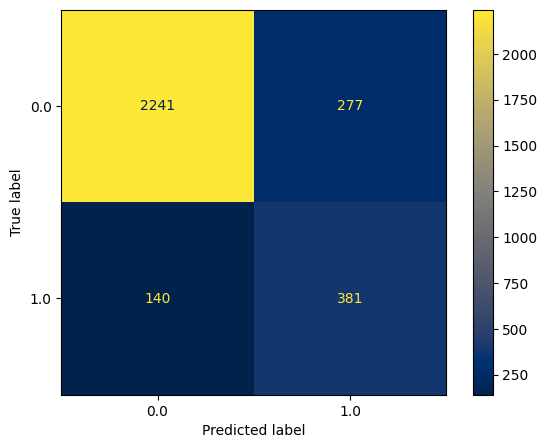

In [79]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(7,5))
y_pred_knn = knn_gridcv.best_estimator_.predict(X_test) # estimating target using the best param

cm_knn = confusion_matrix(y_test, y_pred_knn, labels=knn_gridcv.best_estimator_.classes_)
disp_knn = ConfusionMatrixDisplay(confusion_matrix = cm_knn,
                                  display_labels = knn_gridcv.best_estimator_.classes_)

disp_knn.plot(ax=ax,cmap='cividis')
plt.show()

In [80]:
# the classification report
y_pred_knn = knn_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      2518
         1.0       0.58      0.73      0.65       521

    accuracy                           0.86      3039
   macro avg       0.76      0.81      0.78      3039
weighted avg       0.88      0.86      0.87      3039



KNN with best param {'n_neighbors': 4, 'weights': 'distance'}
- mean test score 91 %
- f1 score 65 %

### Decision Tree

In [81]:
# the compact results
cv_dt = pd.DataFrame(dt_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_dt[retain_cols].sort_values('rank_test_score').head(3)

,params,mean_test_score,rank_test_score
25,"{'max_depth': 15, 'min_samples_leaf': 5}",0.924173,1
20,"{'max_depth': 10, 'min_samples_leaf': 5}",0.923344,2
35,"{'max_depth': 20, 'min_samples_leaf': 5}",0.923046,3


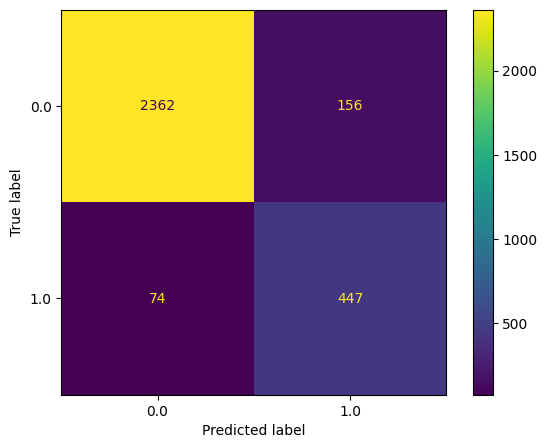

In [82]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(7,5))
y_pred_dt = dt_gridcv.best_estimator_.predict(X_test)

cm_dt = confusion_matrix(y_test, y_pred_dt, labels=dt_gridcv.best_estimator_.classes_)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                             display_labels=dt_gridcv.best_estimator_.classes_)
disp_dt.plot(ax=ax)
plt.show()

In [83]:
# the classification report
y_pred_dt = dt_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      2518
         1.0       0.74      0.86      0.80       521

    accuracy                           0.92      3039
   macro avg       0.86      0.90      0.87      3039
weighted avg       0.93      0.92      0.93      3039



DT with best param {'max_depth': 15, 'min_samples_leaf': 5}	
- mean test score 92 %
- f1 score 80 %

### Random Forest 

In [84]:
# the compact results
cv_rf = pd.DataFrame(rf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_rf[retain_cols].sort_values('rank_test_score').head(3)

,params,mean_test_score,rank_test_score
38,"{'max_depth': 15, 'n_estimators': 40}",0.955731,1
39,"{'max_depth': 15, 'n_estimators': 50}",0.955148,2
37,"{'max_depth': 15, 'n_estimators': 30}",0.954292,3


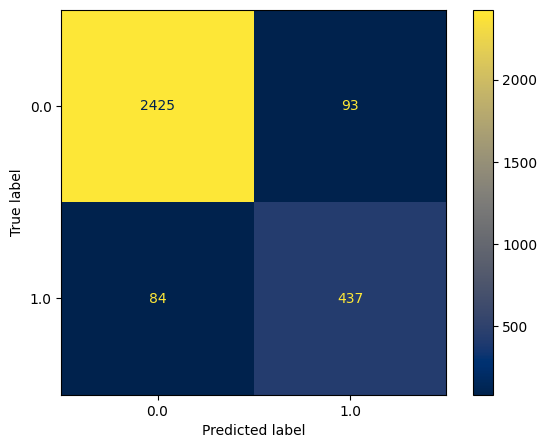

In [85]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(7,5))
y_pred_rf = rf_gridcv.best_estimator_.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_gridcv.best_estimator_.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                             display_labels=rf_gridcv.best_estimator_.classes_)
disp_rf.plot(ax=ax, cmap='cividis')
plt.show()

In [86]:
# the classification report
y_pred_rf = rf_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      2518
         1.0       0.82      0.84      0.83       521

    accuracy                           0.94      3039
   macro avg       0.90      0.90      0.90      3039
weighted avg       0.94      0.94      0.94      3039



RF with best param : {'max_depth': 15, 'n_estimators': 40}
- mean test score 95 %
- f1 score 83 %, BEST perform

# Model Evaluation
We need to build a model that has high precision and sensitivity on churn predictions, therefore we choose f1 score (the precision & recall harmonic averages) 

The random forest outperforms all model on train-test with f1 score, and has the suitable business goals due to the evaluation on confusion matrix.

In [87]:
# the models performance table
tmp = {'Model' : ['Baseline (LogReg)', 'KNN', 'Decision Tree', 'Random Forest'], 
       'Mean Score (%)' : ['-', 91, 92, 95],
       'F1 (%)' : [50, 65, 80, 83]
      }
df_tmp = pd.DataFrame(tmp)
df_tmp

,Model,Mean Score (%),F1 (%)
0,Baseline (LogReg),-,50
1,KNN,91,65
2,Decision Tree,92,80
3,Random Forest,95,83


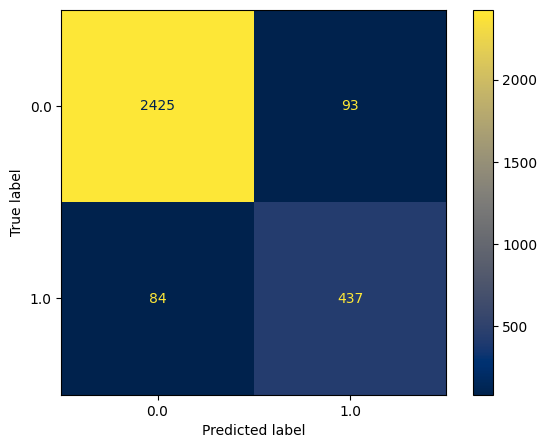

In [88]:
# the best model
rf_best = RandomForestClassifier(random_state=89, max_depth=15, n_estimators=40)

# fit train test
rf_best.fit(X_train_res, y_train_res)

# predict
y_pred_best = rf_best.predict(X_test)

# plot confusion_matrix
fig, ax = plt.subplots(figsize=(7,5))

cm_rf = confusion_matrix(y_test, y_pred_best, 
                         labels=rf_best.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                                 display_labels=rf_best.classes_)
disp_rf.plot(ax=ax, cmap='cividis')
plt.show()

The confusion matrix results for the tuned random forest model :
- **False positive** : predict `churn` and actual `not churn`, 93 customers.
- **False negative** : predict `not churn` and actual `churn`, 84 customers.
- True positive : predict `churn` and actual `churn`, 437 customers.
- True negative : predict `not churn` and actual `not churn`, 2425 customers. 

In [89]:
# the Decision Tree classification report
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      2518
         1.0       0.82      0.84      0.83       521

    accuracy                           0.94      3039
   macro avg       0.90      0.90      0.90      3039
weighted avg       0.94      0.94      0.94      3039



- `82 % precision score`, indicating how precise the model predicts the label. For example, out of 100 predicted churn, 82 of them actually churn.
- `84 % recall score`, means the model reliability to detect churn is quite high, a.k.a the model succesfully predict 84 from 100 actual churned person.
- With a high precission, the labeling results can be more accurate. So we can distribute the point/rewards to the correct customer and avoid the false treatments.
- With a high sensitivity, the model can be sensitve to predicting churn. So we can prevent the future customer form churning.

## Permutation Feature Importance 
We choose permutation importance as an alternative to validate the feature importances at the model. 

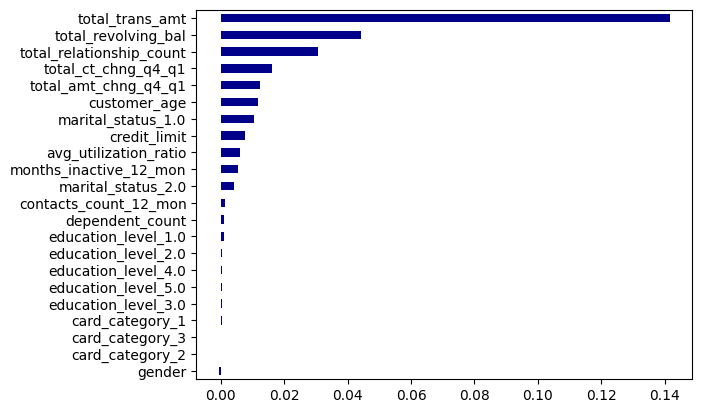

In [90]:
# calculating the result
result = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=89)
forest_importances = pd.Series(result.importances_mean, index=[i for i in X_test.columns])

# visualize the result
forest_importances.sort_values(ascending=True).plot(kind='barh', color='darkblue')

Feature importance shows **what variables most** affect predictions. The top 3 features : 
- `total_trans_amt`
- `total_revolving_bal`
- `total_relationship_count`

From the EDA we just mention some factor need to be monitored, **transaction amount, credit limit, and revolving balance**. By using this feature importance, we can validate the feature that give big impact into the model prediction. It will help to filter the recomendation by choosing the suitable features. It can also improve our next model by employing the feature selection.

Source for Permutation Feature Importance:
- https://medium.com/@ali.soleymani.co/stop-using-random-forest-feature-importances-take-this-intuitive-approach-instead-4335205b933f
- https://explained.ai/rf-importance/
- https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

# Conclusion
**EDA**<br>
- Users tend to churn if they have **large transaction values**, **credit limits**, and **revolving balances**.
- **Gold card users have the most influence on business**, because of the large transaction value and revolving balance.

**Modeling**<br>
- The best predictive model is **Tuned Random Forest**, F1 score of 83%.
- `total_trans_amt` & `total_revolving_bal` are features that have a big impact on model prediction results.

**Recommendation**<br>
- Add services to products such as trip points, cashback vouchers, & discounts on special products.
- Set spending & billing limit reminders every month.
- Implementing tightened Know Your Customer (KYC). Filter risky customers will be able to prevent large revolving balances & balance losses.
